<table><tr>
<td> <img src="images/new-york.jpg" width="600"/> </td>
<td> <img src="images/hollywood-sign.jpg"  width="500"/> </td>
</tr></table>



<h1 align="center">The Big Apple vs Hollywood</h1>
<h1 align="center">(New York city vs Los Angeles)</h1>

Written by A.ABDELSALAM, Oct 16 2020

# 1. Introduction

This report could have so many names, "The class of the titans", "East vs West", "El classico", but the fact is this fight over which of New York city or Los Angeles is the heart of the United States has been going on, and will most likely go on, for many years. Any of these cities alone has a tremendous influence on the rest of the world, maybe more so than any other city on this planet. From the huge impact that Wall Street has on world economics to the influence of Hollywood movies on the everyday lives of each of us, we could speak hours on end about them.  

Aside from this, New York city and Los Angeles remain on the top of the lists of tourists wanting to visit for the first time the US, or for the regular tourists wanting to spend the holidays. Indeed, both are diverse and multicultural and offer a wide palette of experiences that is widely sought after by tourists. In the project we will try to group the neighbourhoods of NYC and LA respectively and draw conclusions on what they both have to offer and if one city stands out more than the other.


# 2. Business Problem


From a business standpoint the aim is to help tourists in choosing their destinations depending on the type of experience proposed by one or the other city. This could also help them not only decide which city to go to but what neighborhood to stay in. This could also be useful for the locals, looking to move from one city to the other, or even from any city to those two. Our analysis will hoefully provide them with a better breakdown of neighborhood compositions, in terms of culture, cuisine and facilitations. Finally, this could be the start of a more serious project for buisness owners looking to open up or branch their business.


# 3. Data Description

We will require geographical location data for both New York City and Los Angeles. The major difference is that New York city is split into boroughs and Los Angeles isn't but that should not be a problem, we will ignore the Boroughs and focus only on all the neighborhoods within New York city rather than focus on one Borough. We will essentially need a dataset that contains all the neighborhoods that exist in each city as well as the the latitude and logitude coordinates of each neighborhood.




## 3.1 New York city

To retrieve our data we will download it for free from this url : https://geo.nyu.edu/catalog/nyu_2451_34572

The JSON file contains a lot of unecessary information and will need to be wrangled appropriately in order to extract the pertinent data. The dataset has information on the Borough as well as Neighborhood, as well as the latitude and longitude for all the neighborhoods, we will limit ouselves to only:
1. *['features]['properties']['name']* : Name of Neighborhoods in NYC
2. *['features]['geometry']['coordinates']* : which is a vector that contains the Latitude and Longitude of the Neighborhoods



## 3.2 Los Angeles

Similarily, we will download a csv readily available for free at this url : https://usc.data.socrata.com/dataset/Los-Angeles-Neighborhood-Map/r8qd-yxsr

The CSV has many unecessary information but we will only retain the information we need about the neighborhoods of Los Angeles county:

1. *name* : Name of Neighbourhoods in LA
2. *latitude* : Latitude of Neighbourhoods in LA
3. *longitude* : Longitude of Neighbourhoods in LA


## 3.3 Foursquare API Data

We will need data about different venues in the different neighbourhoods. To get that that information we will leverage the Foursquare API locational information. Foursquare is a location data provider containing information about all venues and events within an area of interest. Those information can be in the form of venue names, locations, menus, customer ratings and comments and even pictures of the venue. This makes our job easier as we can find all the information centralized in one place. Consequently we will use the foursquare location platform as our only data source since all the required information can be obtained through their API directly from the notebook.

Once we have established a list of neighbourhoods, we can then connect to the Foursquare API to query for information about venues inside each and every neighbourhood. The data returned  from Foursquare query contains information of venues within a specified distance of the longitude and latitude of each neighborhood. The information foe each venue is organized as follows:

1. *Neighbourhood* : Name of the Neighbourhood
2. *Neighbourhood Latitude* : Latitude of the Neighbourhood
3. *Neighbourhood Longitude* : Longitude of the Neighbourhood
4. *Venue* : Name of the Venue
5. *Venue Latitude* : Latitude of Venue
6. *Venue Longitude* : Longitude of Venue
7. *Venue Category* : Category of Venue

For each neighbourhood, we have chosen the radius to be 500 meters and we have limited the number of returned results to 100. Indeed, with a personal free account we are limited to 99500 basic calls a day and 500 premium. This is something to take into condiseration as we will not be able to get ALL venues, and as such our data and thefore analysis will be slightly biased.

Once the data for the venues of each neighborhood in NYC and LA have been gathered we will build our cluser model to group the neghborhoods according to their similarities. The rest of the report will over the methodology, data collection, wrangling, visualization and model construction. We will present and discuss our results and finish off with conclusions.

# 4. Methodology

Since we will be working from within the notebook we need to set up our environment my loading all the necessary packages as follows

In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # installs geopy if not already installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

## 4.1 Data fetching

The entry point of the whole project is getting the data we need from somewhere. As mentionned we will need data for both New York city and Los Angeles: those datasets need to contain a minimum of neighborhood names, which is really the bare minimum, as in fact with only this information we would be able to extract the latitudes and longitudes using other tools within Python. However it implies more work, so it is best if we initially try to get our hands on the most complete dataset in order to facilitate our coding work.

For New York we will get the data in JSON format from the following URL https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json as shown below. It's worth mentionning that this is not the only method to handle JSON files, in fact you could directly read it into a Pandas frame, however with such dense files, you have little control over what Pandas does. In the method below we take it step by step, we take a general look at the JSON result and look for the information we need and then only put those in a dataframe.


``` python
# New York data
!curl -o newyork_data.json https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)  
```
This is what the raw data looks like :

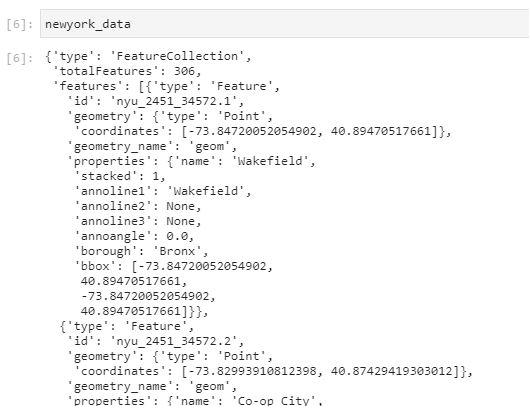

For Los Angeles we can manually download the CSV file and place it in our working folder. Then we can import it directly into a datafram as its structure is fairly simple.

```python
losangeles_data = pd.read_csv('la_neighborhoods.csv')
losangeles_data.head()
```
This what the imported data looks like in a dataframe:

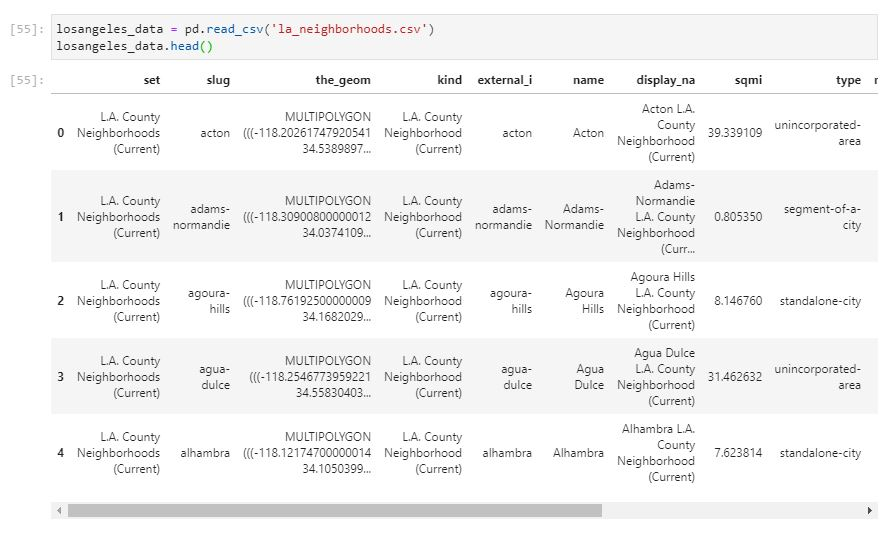

## 4.2 Data pre-processing

Once we have imported the datasets we need to do some clean-up, also known as data wrangling in the data science world. This step is crucial inevitable if we want the rest of the project to be painless. This step can also be longer in some cases.


### 4.2.1 New York city
For New York, we notice that all the information we need is stored under the _features_ key, which is basically a list of all the neighborhoods. Hence, we will define a new variable to extract allt the _features_

```python
ny_neighborhoods_data = newyork_data['features']
```

We will then loop over all the _features_, extract the name of the neighborhoods and their locations, and store them into a dataframe that we will initialize before hand with the appropriate column names. It goes as folows:

```python
# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_neighborhoods = pd.DataFrame(columns=column_names)

# loop over all the features key and store the relevant data in the df
for data in ny_neighborhoods_data:
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
```
The result is the following dataframe: much cleaner and easier to read !


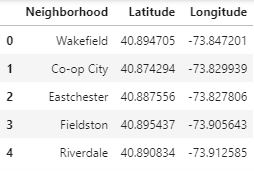

Furthermore we can drop dupicates from the dataframe and return the number of total neighborhoods. It also very important at this early stage that we make sure there are not any null values in the latitudes and longitudes.

```python
# Getting rid of duplicates
ny_neighborhoods = ny_neighborhoods.drop_duplicates(subset=['Neighborhood'])
print('The dataframe has {} neighborhoods.'.format(
        len(ny_neighborhoods['Neighborhood'].unique()),
    )
)

# Making sure there are no null entries
print('There are {} and {} null entries in Latitude and Longitude'.format(ny_neighborhoods['Latitude'].isnull().sum(),ny_neighborhoods['Latitude'].isnull().sum()))


```



### 4.2.2 Los Angeles

For Los Angeles we have already imported the dataset into a dataframe however there are plenty of useless information that we need to get rid of and lighten up the dataframe.

We will select only the columns of interest to us and rename them so they match what wehave previously done with New York.

We will slect only the columns with the name of the neighborhoods, their latitudes and their longitudes. We will also drop duplicates and null entries if there are any.

```python
columns_of_interest = ['name','longitude','latitude']
la_neigborhoods = losangeles_data[columns_of_interest]
la_neigborhoods.columns=['Neighborhood','Latitude','Longitude']
# Droping duplicates
la_neigborhoods = la_neigborhoods.drop_duplicates(subset=['Neighborhood'])

# Checking for NaN
la_neigborhoods.isnull().sum()

```
The result is the following dataframe


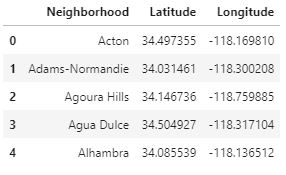

## 4.3 Data visualization

Now that our dataframes are ready to go, we can visualize the maps of New York and Los Angeles with their respective neighbourhoods that we collected. For this we will use the `Folium` package in Python. It's a tool that allows us to overlay pin points over specified latitudes and longitudes with a clickable popup bubble that indicates to us the name of the neighborhood.

Below, the maps of New York city and its neighnorhoods


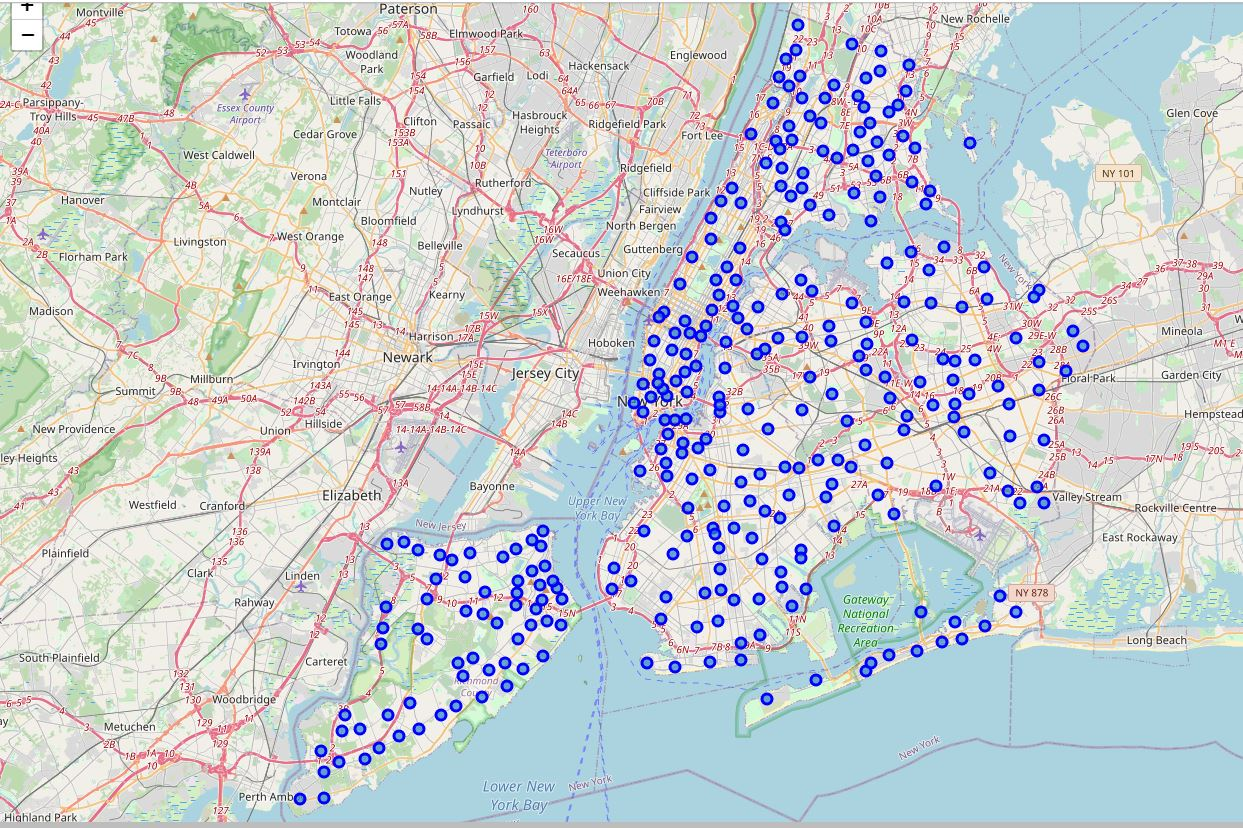

and that of Los Angeles:

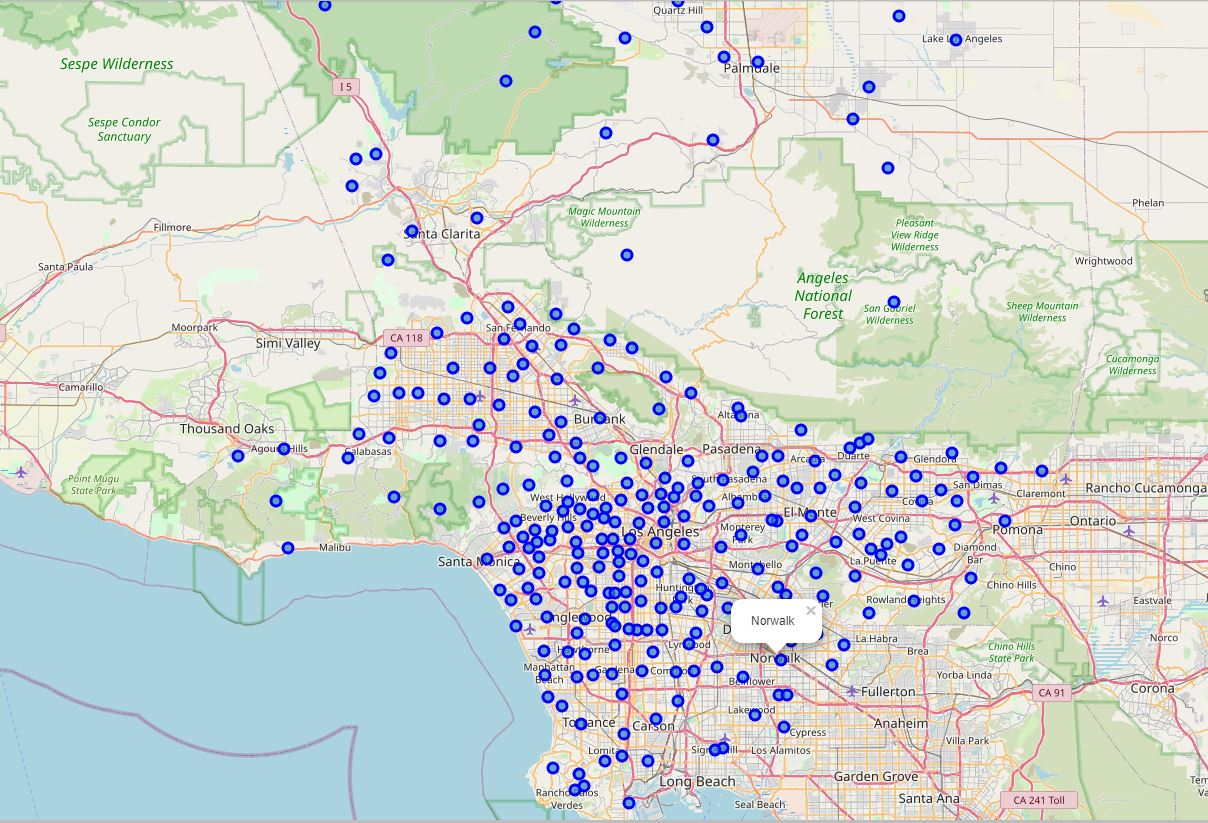

## 4.4 Collecting venues information

The newt step is now to explore the neighborhoods and find out what are the common venues. To accomplish this task we will use `Foursquare` as mentionned earlier. What we want to know are the types of venues, and their location for a given neighborhood. For this we will query the `Foursquare` API giving the geographical coordinates of each neighborhood, a radius of 500 meters around the neihborhood within wich we are interested in getting results, and a limit of 100 venues returned to us because we have a personal free ad therefore limited account.

The function below will take in a list of neighborhood and its coordinate, will query `Foursquare` and return to us dataframe containing a list of all the venues returned by `Foursquare` for all the neighborhoods. The function is as follows :

```python
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

```

We will then call the function to return to us the venues in NYC and LA. Below are two snapshots of the venues dataframes.

New York city venues dataframe :

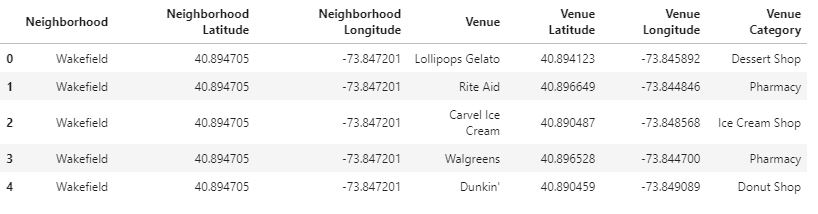

Los Angeles venues dataframe :

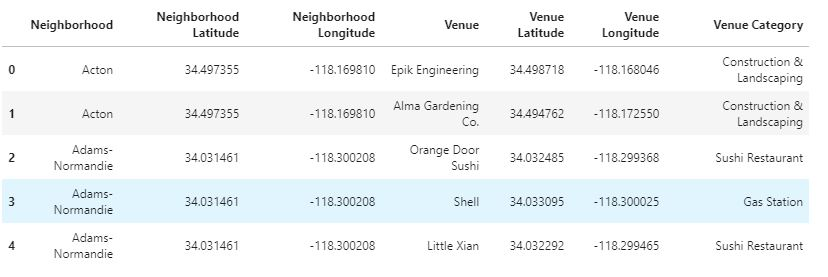

We can see that we have 428 unique venue categories in New York city and 316 in Los Angeles. One could think there are many more types of venues in New York. We will only briefly discuss the difference in number, but with a simple function we can quickly have a look at the categories that are in NY but not in LA and vice versa as follows :

```python
# Define function that returns items in List 1 that are not in List 2 or vice versa
def Diff(li1, li2): 
    return (list(set(li1)-set(li2)) ) 

# Categories in NY and LA
ny_cat = ny_venues['Venue Category'].unique()
la_cat = la_venues['Venue Category'].unique()


ny_diff = Diff(ny_cat, la_cat)
ny_diff
```
Here is a quick glance at a few things that are in NY but not in LA "according" to `Foursquare`

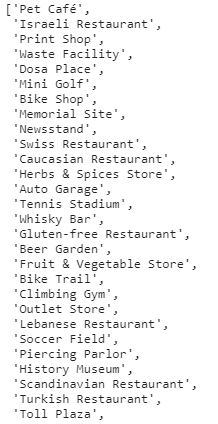

As you can see, without even going to either city we can immediately know that most of those venues are most definitely present in Los Angeles, and even oter cities. What we are seeing here is a different way of calling the same thing : for example, 'Bike shop' might appear in Los Angeles as 'Bicycle shop', that does not mean there aren't any bike shops in LA, just that it might be listed differently in the Los Angeles data. 


## 4.5 One hot encoding

We have now gathered the venues withing 500 meters of each neighborhood but remember that we are interested in the most common venues let's say the top 10 venues, not just any random venue. For this we will use the one-hot-encoding method. This will allow us to convert, in some sense, the categorical data contained in the venue category into a numerical data, something that our future model can work with. Then we group the venue categories by neighborhood and take the mean of the occurence. Think of it as the probability of having a given venue in that neighborhood

The process is as follows :

```python
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

ny_onehot.drop(columns=['Neighborhood'], inplace=True)
# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

# Grouping by neighborhoods and calculating the mean for each venue type
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
```
The result is the following table for New York (the same is done for Los Angeles): 
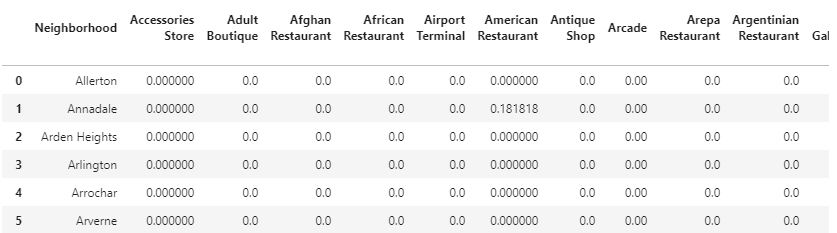

As explained, for each neighorhood we can see the likelihood of there being a given type of venue. With this we can now move on to the next step where we can find the top 10 venues for each neighborhood


## 4.6 Finding the top venues

Using the one hot encoded data we can now pull out the top ten venues for each neighborhood. Remember we mentionned the numerical value under each venue category is equivalent to the probability of finding this type of venue in that neighborhood. Therefore, to find the top 10 venues for each neighborhood we need to find the 10 highest venue 'probabilities'. Thereafter we want to organize that in dataframe to facilitate our analysis later on. The process is as follows:

First, let's write a function to sort the venues in descending order. We will use the functions previously given in the labs
```python
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
```

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

```python 
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ny_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
ny_neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    ny_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

ny_neighborhoods_venues_sorted.head()
```

The result is as follows for New York(the same applies to Los Angeles of course) :

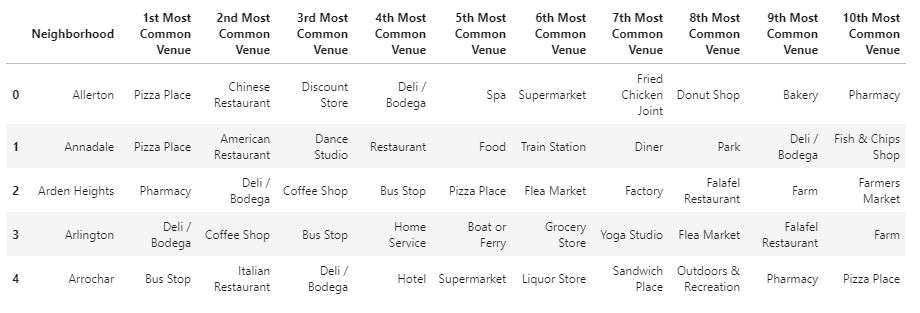

## 4.7 Machine learning model : kMeans Clustering

We now move on to building our clustering model. The idea is to hopefully group the similar neighborhoods together. We will first need to determine the number of clusters for each city. We could make a guess but it would be better to find the optimum number of clusters by evaluating some sort of metric score for each number of clusters. This score is the ***Silhouette Coefficient*** , defined for each cluster. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1] similarily to the linear regression score.

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

The Silhouette Coefficient is defined as such for each sample: 
\begin{align}
SC& = \frac{b-a}{max(a,b)}\\
\end{align}


where _a_ and _b_ are defined as follows :

_a_: The mean distance between a sample and all other points in the same class.

_b_: The mean distance between a sample and all other points in the next nearest cluster.



Now, to find the optimal value of _k_ clusters we will loop through _1..n_ for _n_clusters_ in KMeans and calculate the average Silhouette Coefficient for each sample, we will retain the _k_ with the highest average Silhouette Coefficient.

The algorithm for finding the optimal number of clusters is quite complex and will not be displayed in this report so please refer to the notebook to understand what is done behind the scene. We will only display a few samples of the Silhouette Coefficient plots and briefly comment on them.


As it turned out, the optimal number of cluster is **_3_**, for both New York and Los Angeles. We will therefore build our two models with that in mind as follows:

```python
# Let's cluster new york in 3
n_clusters = 3

#Build our model with n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(ny_grouped_clustering)
```
Once we have run our model, each neighborhood is assigned a cluster label that we will add in our dataframe and display the clusters on their respective maps.

This is now what the Los Angeles dataframe looks like:

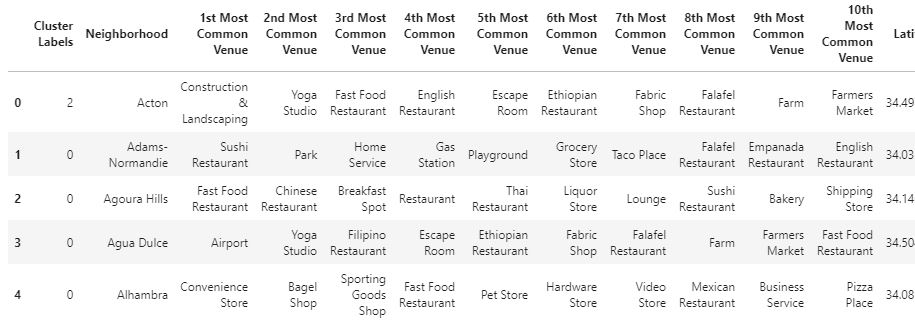

## 5. Results and Discussions


Before diving into our analysis we will first go back to the way we computed the optimal number of clusters. In the figures below, we have on the left the Silhouette coefficient plot for each cluster within a city and on the right the clusters displayed according to their geographic position, for _k=3_ and _k=5_ . What we observe is that for _k=3_ we have most of the neighborhoods clustered in one big cluster whose silhouette coefficient is rather high with most of the silhouette curves ahead of the average silhouette coefficient represented by the dashed red line. On the other hand for _k=5_ not only is the average much lower, but there are plenty of negative coefficients. The ideal plot should have a high average coefficient and with most curves ahead of the average coefficient. Although the _k=3_ plot does not look like the ideal plot, it is the least 'bad' of all.


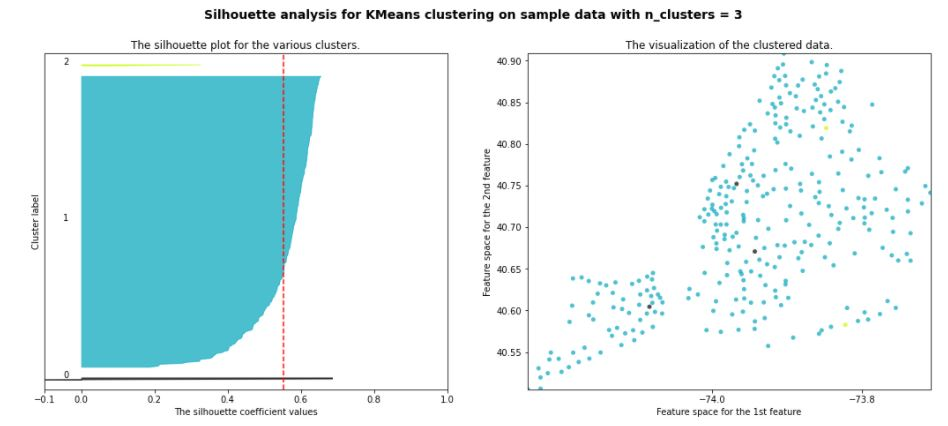

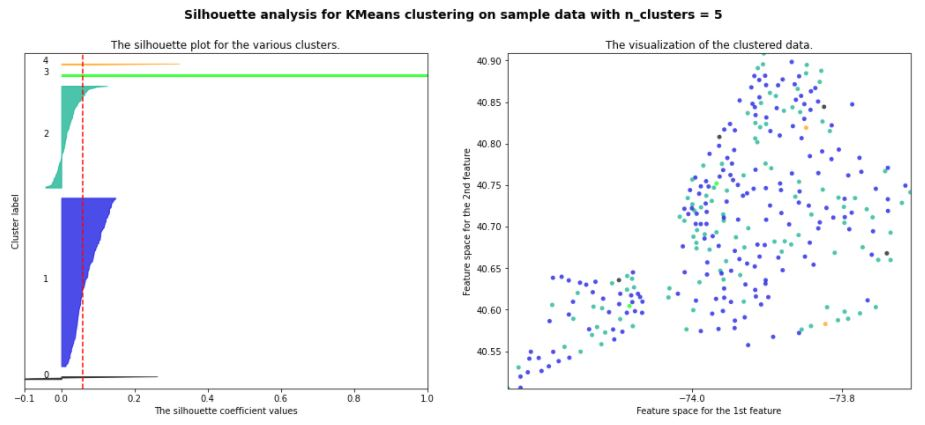

Here are a few more Silhouette plots for _k=8_ and _k=10_ for you to look at :

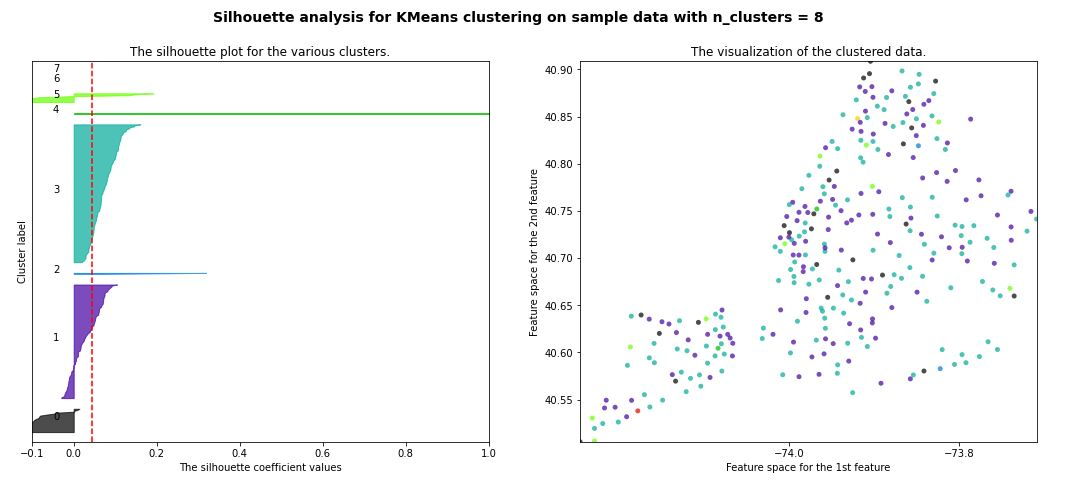

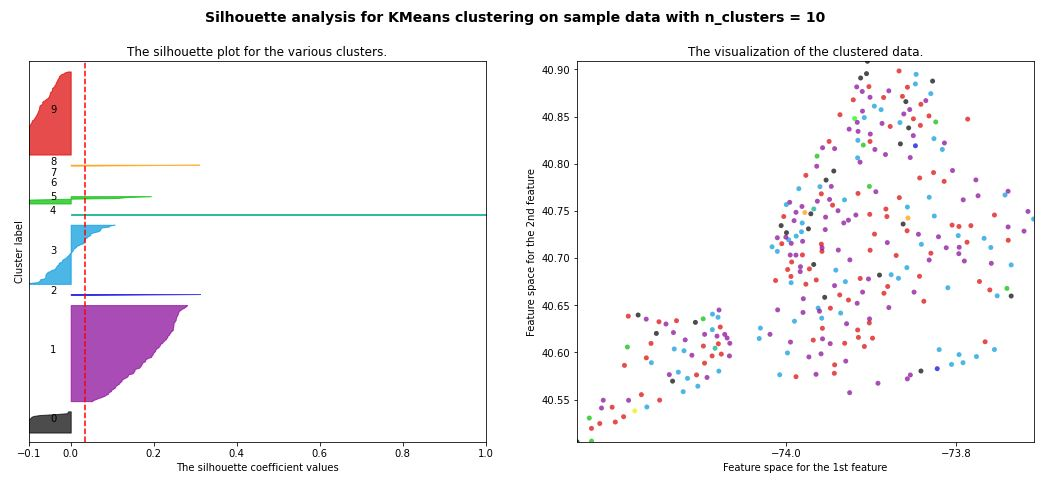

Let's now visualize the clusters in both cities : 

New York city: 

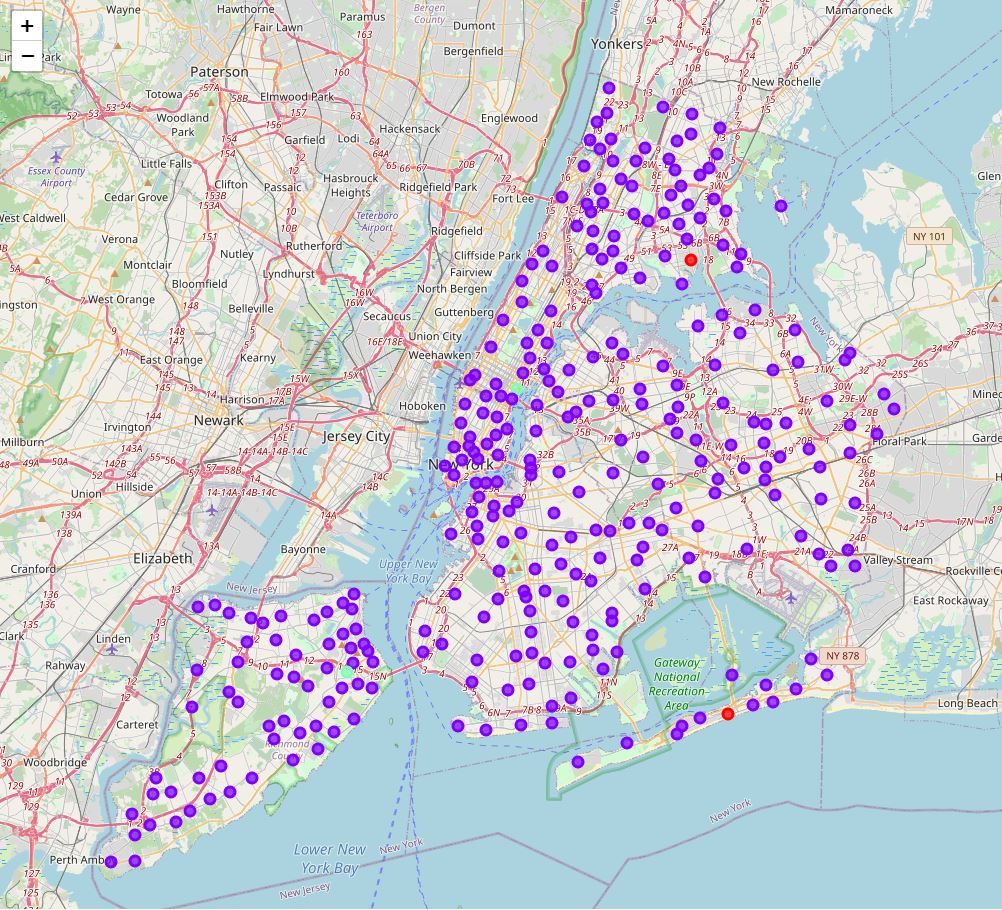


Los Angeles: 


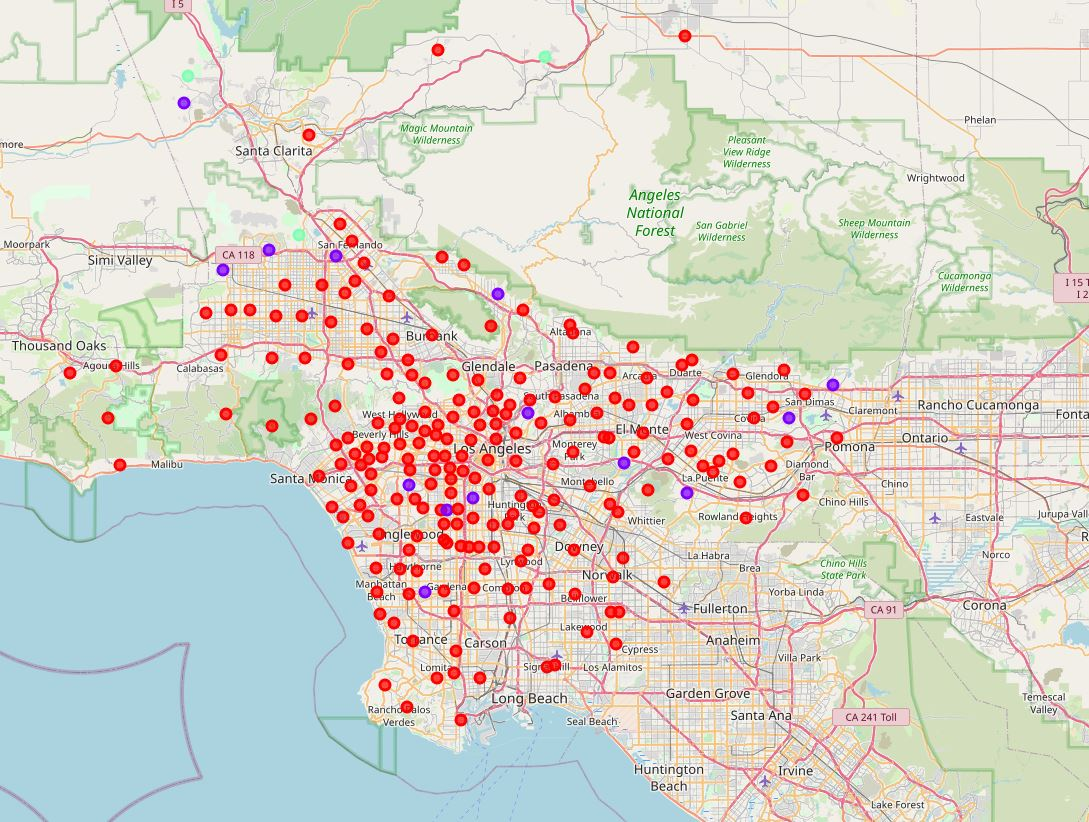

This is all looking good but in order to have a better understanding of what makes each cluster what it is, let us use wordclouds. By doing so we will see what the most common venues are with a quick glance. Below are the three wordclouds for each cluster:

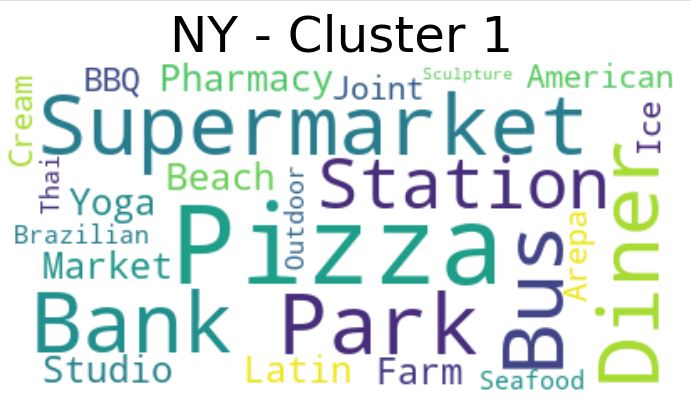

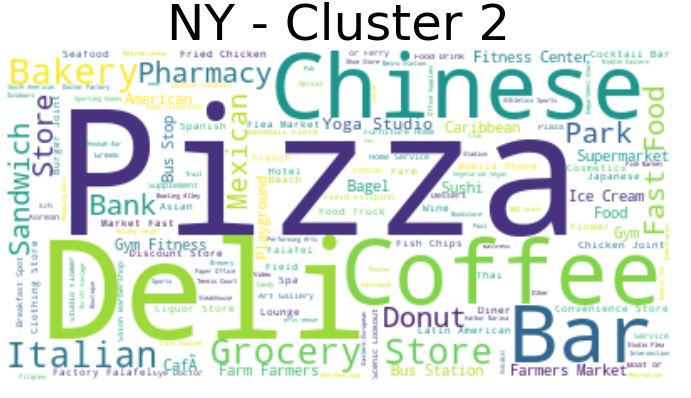
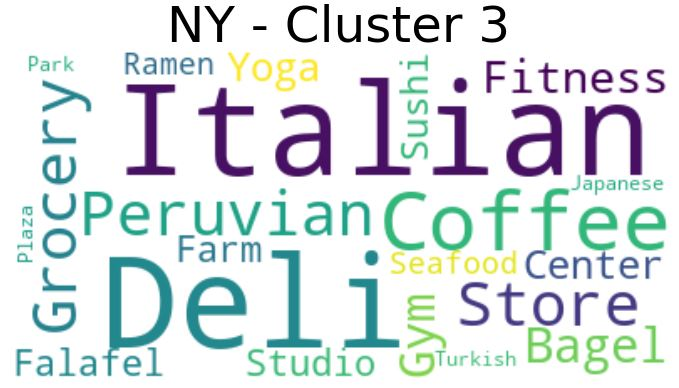

and for Los Angeles:


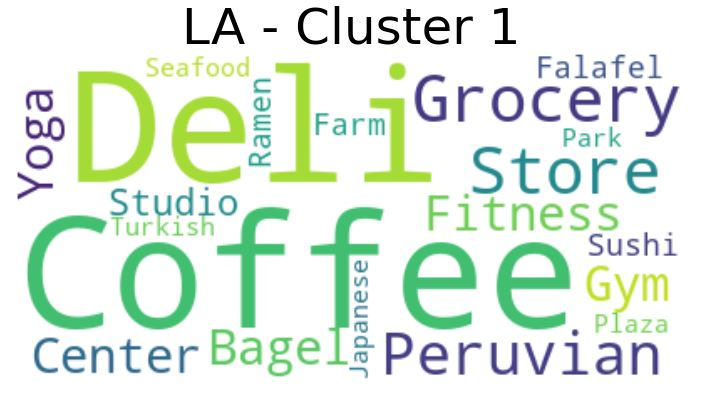
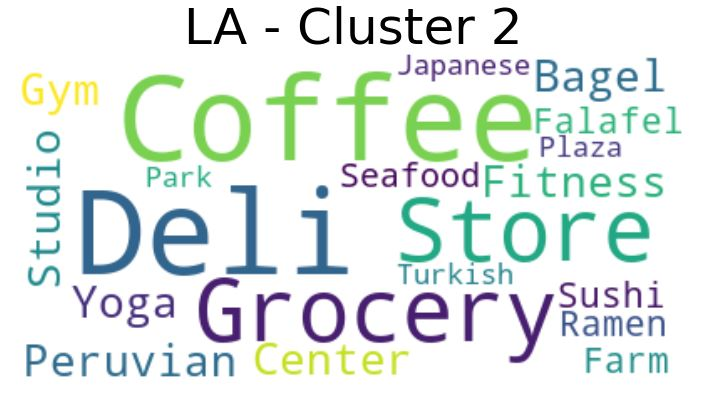
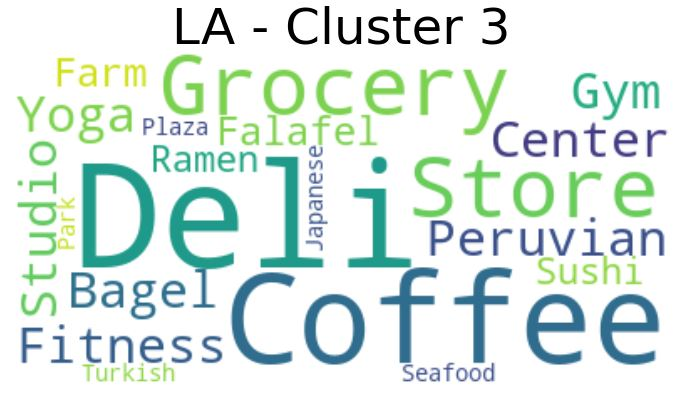

What we can take from all those wordclouds is that while there are similarities there are still some differences. Both cities' neighborhoods are clearly very multicultural. Common venues are deli's and supermarkets, asian cuisine and international cuisine like turkish or peruvian. Both have parks to offer, as well as gyms and fitness centers, conveying a fit lifestyle in both cities.

However, there are a few things that stand out in both cities. New York offers seems to offer have specific food venues that dominate the rest : Italian for instance, clearly under-represented in Los Angeles, which is understable given New York's immigration history. Pizza is also one of the most recurring themes, which  comes to no surprise after Italian but also because NYC is renowned for their quality pizzas. Other cuisines such as, chinese, mexican are also more dominent in New York than Los Angeles. 

Furthermore, we can clearly see that NYC is more of a business city than LA, we see the words _bank_, _bus_ and _station_ recurring often in NYC and not a single time in LA. Again no surprise, NYC is the financial capital of the US and has one of the best transportation system in the world.

What we can say about Los Anglese, mainly from the words that do not come up in LA but are in NYC, is that it displays a more relaxed image. The word _coffee_ is also more prominent in LA, commonly associated with gatherings and the outdoors. In fact, the words _Yoga_ and fitness related words occur more often in LA, and the abscence of the word _fast-food_ conveys a healthier lifetstyle in LA. This is all most likely due to the sun.

## 6 Conclusions

The purpose of this project was to explore and compare the cities of New York and Los Angeles in order to see how attractive they could be for tourists or even for people looking to immigrate or migrate to either of these two cities.

We have successfully gathered and explored the data, using the available datasets online as well as the data available from _Foursquare_. We were then able to cluster the neighborhoods with a kMeans clustering model in order to better compare the two cities. 

What we can draw from this project is that those two cities are very much alike. Both are very multicultural, as shown by the various cuisine venues in both cities. Both are also considered to be fit cities with parks, gyms and fitness centers. 

There are however some differences. New york seems to have a stronger Italian and Chinese influence. This could be a selling point for immigrants from these two countries for instance. New York also seems to be more of a business city, that could be a positive point for stakeholders looking to start or expand their business. More over, New York has better transportation system, more convenient for people with no cars, student or tourists alike. In fact this could mean selling point for tourists, as renting a car in Los Angeles could turn out to be expensive and hinder the vacation budget. On the contrary, Los Angeles seems to be a healthier city, reflected by the lack of fast-food, and a more relaxed city.

All in all, the results of this project have shown that while there are similarities in both cities, there are some arguments that could favor one city over the other whether one is looking to spend the holidays, or start a business or just relax.

# References

1.   [Silhouette Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

2. [Foursquare API](https://foursquare.com)
